In [1]:
##import packages
library(ggplot2)
library(microbiome)
library(phyloseq)
library("tidyverse")
library("dplyr")
library(vegan)
library("lubridate")
library("DESeq2")
library("GGally")
library("ggpmisc")
library(patchwork)
library(lsmeans)
library('pbkrtest')
library("speedyseq")

Loading required package: phyloseq


microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2022 Leo Lahti, 
    Sudarshan Shetty et al. <microbiome.github.io>



Attaching package: ‘microbiome’


The following object is masked from ‘package:ggplot2’:

    alpha


The following object is masked from ‘package:base’:

    transform


── Attaching core tidyverse packages ────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ──────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ microbiome::alpha() masks ggplot2::alpha()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: permute

Loading required package: lattic

In [2]:
library("lme4"); packageVersion("lme4")
packageVersion("microbiome")
packageVersion('Vegan')

[1] ‘1.1.35.2’

[1] ‘1.24.0’

[1] ‘2.6.4’

In [3]:
#import data from r data
load("/Users/stephanie.rosales/Documents/omics_projects/POR_16S/CoralPersistence/data/POR_counts_4_analysis.RData")
load("/Users/stephanie.rosales/Documents/omics_projects/POR_16S/CoralPersistence/data/POR_taxo_4_analysis.RData")
## Need taxonomy and counts as matrices
euk_ASVs <- read.table("/Users/stephanie.rosales/Documents/omics_projects/POR_16S/CoralPersistence/data/euk_asvs.txt",
                      stringsAsFactors = FALSE) %>% as.matrix() %>% as.list()

taxo_mat <- POR_taxo_4_analysis #%>%
  #rownames_to_column %>%
  #filter(rowname != c('ASV_2',"ASV_10673", 'ASV_10883')) %>%
  #column_to_rownames("rowname")
count_mat <- as.matrix(POR_counts_4_analysis)
count_mat <- as.matrix(POR_counts_4_analysis)

In [4]:
# change factor levels
meta = read.csv ("/Users/stephanie.rosales/Documents/omics_projects/POR_16S/CoralPersistence/metadata/POR_combo_meta.csv",
row.names=1, header = T)%>%
  mutate(
    Month = factor(Month, levels = month.name)
  ) %>%
  arrange(Month) %>%
arrange(collection_date)

In [5]:
# create phyloseq object
ASV <- otu_table(as.matrix(POR_counts_4_analysis), 
                 taxa_are_rows = T)
TAX <- tax_table(as.matrix(taxo_mat))
SAMP <- sample_data(meta)

ps <- phyloseq(ASV, TAX, SAMP)
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 27534 taxa and 363 samples ]:
sample_data() Sample Data:        [ 363 samples by 58 sample variables ]:
tax_table()   Taxonomy Table:     [ 27534 taxa by 7 taxonomic ranks ]:
taxa are rows

In [6]:
#filter euks
euk_asvs <- c("ASV_10673","ASV_10883",	"ASV_11806","ASV_12333",	"ASV_12335",	"ASV_13587",	"ASV_14757",	"ASV_15238",	"ASV_15259",	"ASV_16364",	"ASV_16936",	"ASV_17406",	"ASV_18096",	"ASV_18375",	"ASV_18682",	"ASV_19529",	"ASV_19795",	"ASV_19953",	"ASV_2",	"ASV_20640",	"ASV_2100",	"ASV_22284",	"ASV_22692",	"ASV_23038",	"ASV_23144",	"ASV_24135",	"ASV_24243",	"ASV_27014",	"ASV_29665",	"ASV_30547",	"ASV_30626",	"ASV_30884",	"ASV_4161",	"ASV_4498",	"ASV_476",	"ASV_4797",	"ASV_4966",	"ASV_5018",	"ASV_5118",	"ASV_5154",	"ASV_6282",	"ASV_653",	"ASV_6843",	"ASV_7264",	"ASV_7427",	"ASV_8",	"ASV_9248",	"ASV_9692")
allTaxa = taxa_names(ps)
allTaxa <- allTaxa[!(allTaxa %in% euk_asvs)]
ps_fill_euk = prune_taxa(allTaxa, ps)
# new phyloseq object with just the taxa you kept.
ps_fill_euk

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 27486 taxa and 363 samples ]:
sample_data() Sample Data:        [ 363 samples by 58 sample variables ]:
tax_table()   Taxonomy Table:     [ 27486 taxa by 7 taxonomic ranks ]:
taxa are rows

In [7]:
#merge samples from same cluster
ps_merge = merge_samples2(ps_fill_euk, "geno_clus")
ps_merge

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 27486 taxa and 125 samples ]:
sample_data() Sample Data:        [ 125 samples by 58 sample variables ]:
tax_table()   Taxonomy Table:     [ 27486 taxa by 7 taxonomic ranks ]:
taxa are rows

In [8]:
#filter low prevalent and abundant ASVs
ps_fill= filter_taxa(ps_merge, function(x) sum(x > 0) > (0.0*length(x)), TRUE)
                     ps_fill

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 27459 taxa and 125 samples ]:
sample_data() Sample Data:        [ 125 samples by 58 sample variables ]:
tax_table()   Taxonomy Table:     [ 27459 taxa by 7 taxonomic ranks ]:
taxa are rows

In [9]:
#counts across taxonomy
sapply(as.data.frame(tax_table(ps_fill)), function(x) sum(is.na(x)))

domain  phylum   class   order  family   genus species 
   6352    9232   10010   14407   16244   20799   27459

In [10]:
microbiome::summarize_phyloseq(ps_fill)

Compositional = NO2

1] Min. number of reads = 168762] Max. number of reads = 4116713] Total number of reads = 185409174] Average number of reads = 148327.3365] Median number of reads = 1287327] Sparsity = 0.966274081357666] Any OTU sum to 1 or less? YES8] Number of singletons = 409] Percent of OTUs that are singletons 
        (i.e. exactly one read detected across all samples)0.14567172875924110] Number of sample variables are: 58collection_dateSpeed.cm.s.Bearing.degrees.Velocity.N.cm.s.Velocity.E.cm.s.Temperature.C.reefGenotypeFragment_numberMonthYearFragment_numdaySurveyLiveFragSurvivorship_reefSurvivorshipLWHAdjusted.AreaS01FragCountYear.xSi.uM.NO2.uM.N.N.uM.NO3.uM.PO4.uM.sample_IDsample_ID2HealthMonth.xSamp_tripjoining_infoorderspeciestime_ReefClustersampling_tripgeno_clusXcolour_reefcolour_genotypecolour_reef_genotypecolour_timepointcolour_timepoint_reefcluster_latitudecluster_longitudecluster_depthdepthYear.yMonth.yLat_decimalLong_decimalavgchla_mgm.3sdchla_mgm.3avgSST_degCsdSS

[[1]]
[1] "1] Min. number of reads = 16876"

[[2]]
[1] "2] Max. number of reads = 411671"

[[3]]
[1] "3] Total number of reads = 18540917"

[[4]]
[1] "4] Average number of reads = 148327.336"

[[5]]
[1] "5] Median number of reads = 128732"

[[6]]
[1] "7] Sparsity = 0.96627408135766"

[[7]]
[1] "6] Any OTU sum to 1 or less? YES"

[[8]]
[1] "8] Number of singletons = 40"

[[9]]
[1] "9] Percent of OTUs that are singletons \n        (i.e. exactly one read detected across all samples)0.145671728759241"

[[10]]
[1] "10] Number of sample variables are: 58"

[[11]]
 [1] "collection_date"       "Speed.cm.s."           "Bearing.degrees."     
 [4] "Velocity.N.cm.s."      "Velocity.E.cm.s."      "Temperature.C."       
 [7] "reef"                  "Genotype"              "Fragment_number"      
[10] "Month"                 "Year"                  "Fragment_num"         
[13] "day"                   "Survey"                "LiveFrag"             
[16] "Survivorship_reef"     "Survivorship"          "L"                    
[19] "W"                     "H"                     "Adjusted.Area"        
[22] "S01FragCount"          "Year.x"                "Si.uM."               
[25] "NO2.uM."               "N.N.uM."               "NO3.uM."              
[28] "PO4.uM."               "sample_ID"             "sample_ID2"           
[31] "Health"                "Month.x"               "Samp_trip"            
[34] "joining_info"          "order"                 "species"              
[37] "time_Reef"             "Cluster"               "sampling_trip"        
[40] "geno_clus"             "X"                     "colour_reef"          
[43] "colour_genotype"       "colour_reef_genotype"  "colour_timepoint"     
[46] "colour_timepoint_reef" "cluster_latitude"      "cluster_longitude"    
[49] "cluster_depth"         "depth"                 "Year.y"               
[52] "Month.y"               "Lat_decimal"           "Long_decimal"         
[55] "avgchla_mgm.3"         "sdchla_mgm.3"          "avgSST_degC"          
[58] "sdSST_degC"

In [11]:
#rarefy for alpha-diversity 
    ps_fill_rare <- phyloseq::rarefy_even_depth(ps_fill, rngseed = 123, replace = FALSE, sample.size=15000)          

`set.seed(123)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(123); .Random.seed` for the full vector

...

7073OTUs were removed because they are no longer 
present in any sample after random subsampling


...



phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 20386 taxa and 125 samples ]:
sample_data() Sample Data:        [ 125 samples by 58 sample variables ]:
tax_table()   Taxonomy Table:     [ 20386 taxa by 7 taxonomic ranks ]:
taxa are rows

In [12]:

adiv <- data.frame(
  "Shannon" = phyloseq::estimate_richness(ps_fill_rare, measures = "Shannon")) %>% rownames_to_column("sample_bag")
head(adiv)

,sample_bag,Shannon
,<chr>,<dbl>
1,ML2_78_cf_Trip_3,2.144486
2,CN4_35_cf_Trip_3,4.487037
3,CN4_25_cf_Trip_3,2.806583
4,HS1_18_cf_Trip_3,2.780941
5,HS1_17_cf_Trip_3,4.011722
6,HS1_15_cf_Trip_3,3.510937


In [13]:
#normalize the data
adiv_trans =adiv %>%
mutate(Shannon_trans = log10(Shannon))
head(adiv_trans)

,sample_bag,Shannon,Shannon_trans
,<chr>,<dbl>,<dbl>
1,ML2_78_cf_Trip_3,2.144486,0.3313232
2,CN4_35_cf_Trip_3,4.487037,0.6519596
3,CN4_25_cf_Trip_3,2.806583,0.4481778
4,HS1_18_cf_Trip_3,2.780941,0.4441918
5,HS1_17_cf_Trip_3,4.011722,0.6033309
6,HS1_15_cf_Trip_3,3.510937,0.5454230



	Shapiro-Wilk normality test

data:  adiv_trans$Shannon_trans
W = 0.9874, p-value = 0.305


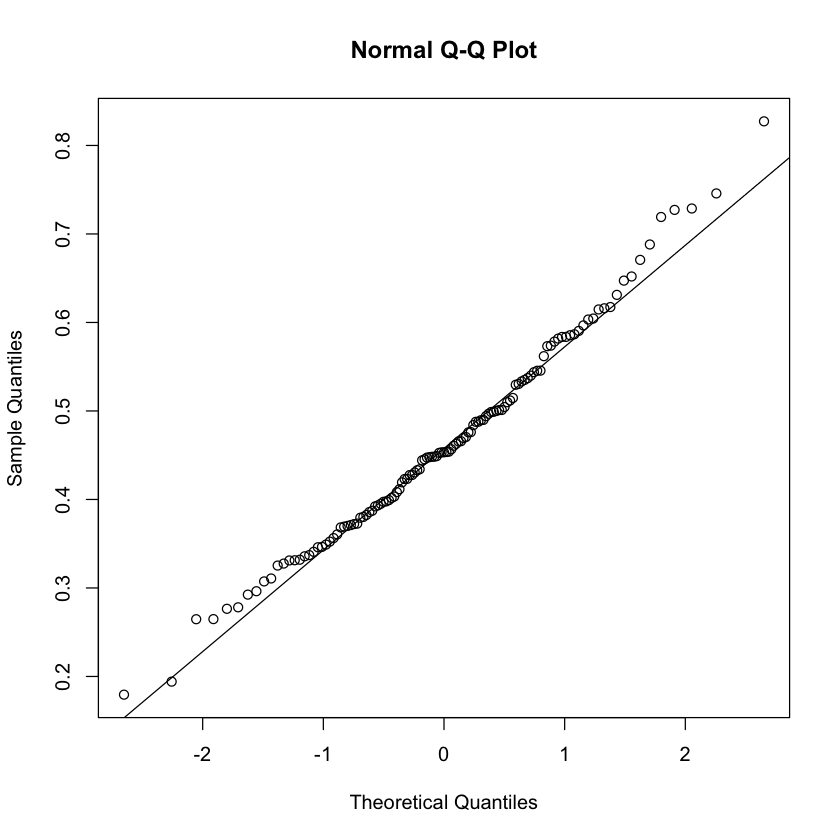

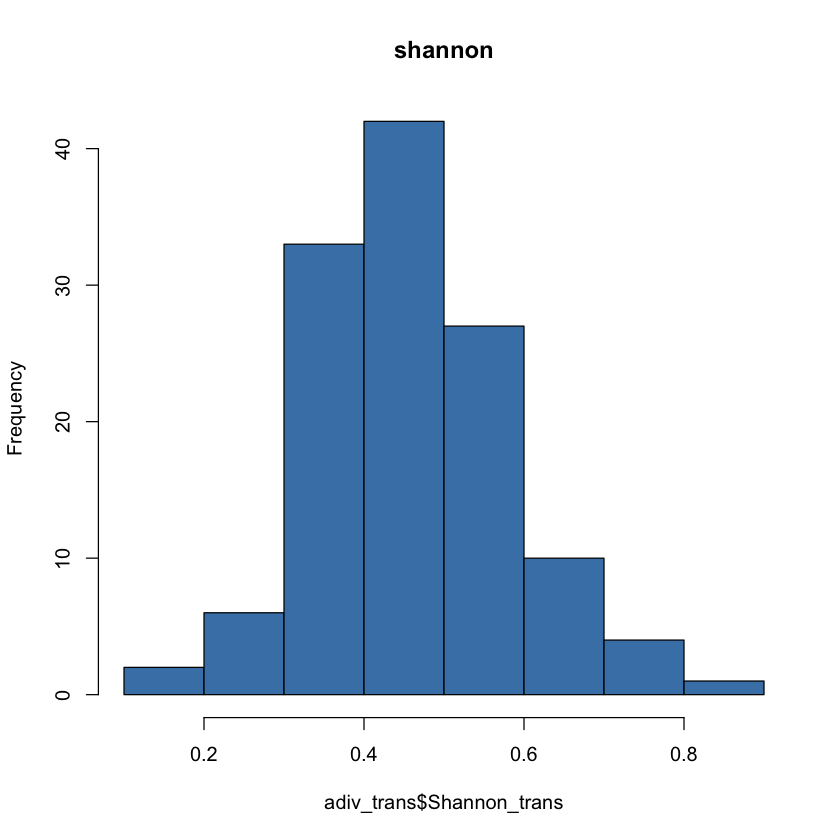

In [14]:
#inspect normalized data
qqnorm(adiv_trans$Shannon_trans)
qqline(adiv_trans$Shannon_trans)
shapiro.test(adiv_trans$Shannon_trans)
hist(adiv_trans$Shannon_trans, col='steelblue', main='shannon')

In [15]:
#combine data with enviornmental data
ps_ra_meta= as(sample_data(ps_fill_rare), "data.frame")
ps_ra_meta_envs = ps_ra_meta %>% select("Genotype", "Samp_trip", "reef",'Speed.cm.s.', 'NO2.uM.', 'NO3.uM.', 'PO4.uM.', 'Si.uM.',
                "Speed.cm.s.", "avgSST_degC", "avgchla_mgm.3", "cluster_depth", "Survivorship_reef")
head(ps_ra_meta_envs)

alpha_envs=cbind(ps_ra_meta_envs, adiv_trans)
head(alpha_envs)

,Genotype,Samp_trip,reef,Speed.cm.s.,NO2.uM.,NO3.uM.,PO4.uM.,Si.uM.,avgSST_degC,avgchla_mgm.3,cluster_depth,Survivorship_reef
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ML2_78_cf_Trip_3,ML2,Trip_3,cf,4.852118,0.032,0.861,0.0685,0.706,29.63623,1.792092,-20.9,0.15
CN4_35_cf_Trip_3,CN4,Trip_3,cf,4.852118,0.032,0.861,0.0685,0.706,29.63623,1.792092,-17.9,0.23
CN4_25_cf_Trip_3,CN4,Trip_3,cf,4.852118,0.032,0.861,0.0685,0.706,29.63623,1.792092,-20.8,0.23
HS1_18_cf_Trip_3,HS1,Trip_3,cf,4.852118,0.032,0.861,0.0685,0.706,29.63623,1.792092,-18.8,0.80
HS1_17_cf_Trip_3,HS1,Trip_3,cf,4.852118,0.032,0.861,0.0685,0.706,29.63623,1.792092,-17.8,NA
HS1_15_cf_Trip_3,HS1,Trip_3,cf,4.852118,0.032,0.861,0.0685,0.706,29.63623,1.792092,-17.6,0.90


## linear mixed models for shannon diversity 

In [20]:
mixed.lmer_geno <- lmer(Shannon_trans ~ -1 + Genotype + (1|Samp_trip:reef) , data =alpha_all)
summary(mixed.lmer_geno)

emmeans(mixed.lmer_geno, pairwise ~ -1 + Genotype, adjust="tukey")

Linear mixed model fit by REML ['lmerMod']
Formula: Shannon_trans ~ -1 + Genotype + (1 | Samp_trip:reef)
   Data: alpha_all

REML criterion at convergence: -175.1

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.00622 -0.64671 -0.08758  0.73311  2.93537 

Random effects:
 Groups         Name        Variance  Std.Dev.
 Samp_trip:reef (Intercept) 0.0004246 0.02061 
 Residual                   0.0119579 0.10935 
Number of obs: 125, groups:  Samp_trip:reef, 12

Fixed effects:
            Estimate Std. Error t value
GenotypeCN2  0.49399    0.01894   26.08
GenotypeCN4  0.50726    0.02202   23.03
GenotypeHS1  0.44500    0.01942   22.91
GenotypeML2  0.39981    0.02239   17.86

Correlation of Fixed Effects:
            GntCN2 GntCN4 GntHS1
GenotypeCN4 0.085               
GenotypeHS1 0.096  0.085        
GenotypeML2 0.083  0.082  0.083 

$emmeans
 Genotype emmean     SE   df lower.CL upper.CL
 CN2       0.494 0.0189 62.7    0.456    0.532
 CN4       0.507 0.0221 75.7    0.463    0.551
 HS1       0.445 0.0194 66.5    0.406    0.484
 ML2       0.400 0.0225 79.8    0.355    0.445

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$contrasts
 contrast  estimate     SE  df t.ratio p.value
 CN2 - CN4  -0.0133 0.0279 115  -0.476  0.9643
 CN2 - HS1   0.0490 0.0258 111   1.899  0.2345
 CN2 - ML2   0.0942 0.0282 115   3.341  0.0061
 CN4 - HS1   0.0623 0.0282 114   2.209  0.1269
 CN4 - ML2   0.1074 0.0301 112   3.567  0.0030
 HS1 - ML2   0.0452 0.0285 114   1.588  0.3898

Degrees-of-freedom method: kenward-roger 
P value adjustment: tukey method for comparing a family of 4 estimates 


In [21]:
mixed.lmer_geno <- lmer(Shannon_trans ~ -1 + reef + (1|Genotype:Samp_trip) , data =alpha_all)
summary(mixed.lmer_geno)

emmeans(mixed.lmer_geno, pairwise ~ -1 + reef, adjust="tukey")

Linear mixed model fit by REML ['lmerMod']
Formula: Shannon_trans ~ -1 + reef + (1 | Genotype:Samp_trip)
   Data: alpha_all

REML criterion at convergence: -171.4

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.06179 -0.65698  0.04547  0.64340  2.83430 

Random effects:
 Groups             Name        Variance Std.Dev.
 Genotype:Samp_trip (Intercept) 0.002149 0.04636 
 Residual                       0.011777 0.10852 
Number of obs: 125, groups:  Genotype:Samp_trip, 16

Fixed effects:
        Estimate Std. Error t value
reefcf   0.47869    0.02316   20.67
reefndr  0.47578    0.01963   24.24
reefpr   0.44017    0.01965   22.40

Correlation of Fixed Effects:
        reefcf refndr
reefndr 0.299        
reefpr  0.301  0.348 

$emmeans
 reef emmean     SE   df lower.CL upper.CL
 cf    0.479 0.0233 58.7    0.432    0.525
 ndr   0.476 0.0196 39.3    0.436    0.515
 pr    0.440 0.0197 39.2    0.400    0.480

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$contrasts
 contrast estimate     SE  df t.ratio p.value
 cf - ndr  0.00291 0.0256 112   0.114  0.9929
 cf - pr   0.03852 0.0255 112   1.508  0.2910
 ndr - pr  0.03561 0.0224 108   1.587  0.2555

Degrees-of-freedom method: kenward-roger 
P value adjustment: tukey method for comparing a family of 3 estimates 


In [22]:
mixed.lmer_geno <- lmer(Shannon_trans ~ -1 + Samp_trip + (1|Genotype) , data =alpha_all)
summary(mixed.lmer_geno)

emmeans(mixed.lmer_geno, pairwise ~ -1 + Samp_trip, adjust="tukey")

Linear mixed model fit by REML ['lmerMod']
Formula: Shannon_trans ~ -1 + Samp_trip + (1 | Genotype)
   Data: alpha_all

REML criterion at convergence: -172.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9846 -0.6827 -0.0953  0.7427  3.1759 

Random effects:
 Groups   Name        Variance Std.Dev.
 Genotype (Intercept) 0.00186  0.04313 
 Residual             0.01200  0.10953 
Number of obs: 125, groups:  Genotype, 4

Fixed effects:
                Estimate Std. Error t value
Samp_tripTrip_2  0.43361    0.02860   15.16
Samp_tripTrip_3  0.47843    0.02880   16.61
Samp_tripTrip_4  0.49653    0.03001   16.54
Samp_tripTrip_5  0.44229    0.02946   15.01

Correlation of Fixed Effects:
            Sm_T_2 Sm_T_3 Sm_T_4
Smp_trpTr_3 0.565               
Smp_trpTr_4 0.543  0.540        
Smp_trpTr_5 0.553  0.550  0.531 

$emmeans
 Samp_trip emmean     SE   df lower.CL upper.CL
 Trip_2     0.434 0.0286 6.30    0.364    0.503
 Trip_3     0.478 0.0288 6.46    0.409    0.548
 Trip_4     0.497 0.0300 7.56    0.427    0.567
 Trip_5     0.442 0.0295 7.06    0.373    0.512

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$contrasts
 contrast        estimate     SE  df t.ratio p.value
 Trip_2 - Trip_3 -0.04482 0.0268 118  -1.674  0.3420
 Trip_2 - Trip_4 -0.06292 0.0281 118  -2.242  0.1180
 Trip_2 - Trip_5 -0.00868 0.0275 118  -0.316  0.9890
 Trip_3 - Trip_4 -0.01811 0.0282 118  -0.641  0.9184
 Trip_3 - Trip_5  0.03614 0.0277 118   1.307  0.5606
 Trip_4 - Trip_5  0.05424 0.0288 118   1.883  0.2410

Degrees-of-freedom method: kenward-roger 
P value adjustment: tukey method for comparing a family of 4 estimates 


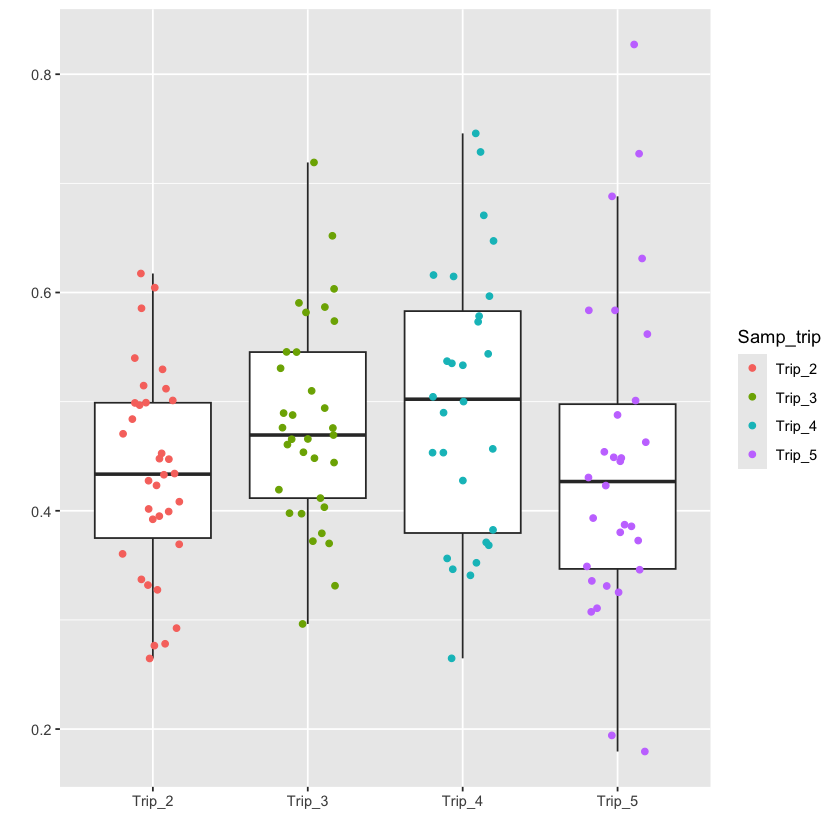

In [23]:
alpha_all %>%
 ggplot(aes(x = Samp_trip, y = Shannon_trans))  +
  geom_boxplot(outlier.color = NA)  +
geom_jitter(aes(color = Samp_trip), height = 0, width = .2) +
  labs(x = "", y = "")

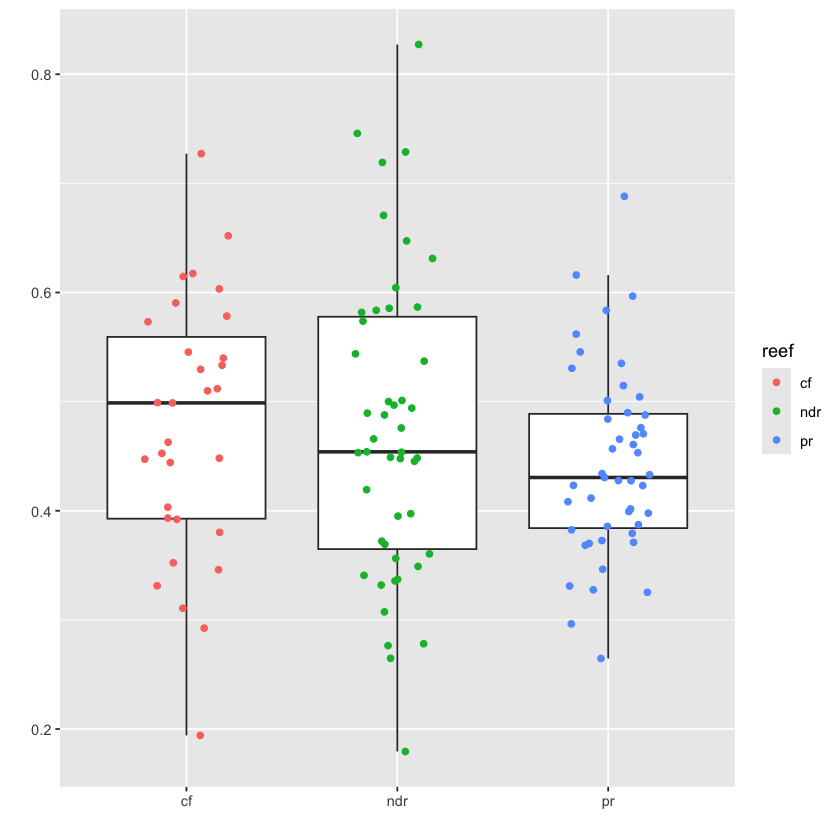

In [24]:
alpha_all %>%
 ggplot(aes(x = reef, y = Shannon_trans))  +
  geom_boxplot(outlier.color = NA)  +
geom_jitter(aes(color = reef), height = 0, width = .2) +
  labs(x = "", y = "")

In [25]:
mixed.lmer_interaction <- lmer(Shannon_trans ~ -1 + Genotype:reef + (1|reef), data = alpha_all)
summary(mixed.lmer_interaction)
emmeans(mixed.lmer_interaction, pairwise ~ -1 + Genotype:reef, adjust = "tukey")

Linear mixed model fit by REML ['lmerMod']
Formula: Shannon_trans ~ -1 + Genotype:reef + (1 | reef)
   Data: alpha_all

REML criterion at convergence: -150.9

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.48303 -0.67120  0.05193  0.63068  2.52547 

Random effects:
 Groups   Name        Variance  Std.Dev.
 reef     (Intercept) 0.0002238 0.01496 
 Residual             0.0120941 0.10997 
Number of obs: 125, groups:  reef, 3

Fixed effects:
                    Estimate Std. Error t value
GenotypeCN2:reefcf   0.52111    0.03509  14.849
GenotypeCN4:reefcf   0.49779    0.05699   8.735
GenotypeHS1:reefcf   0.47403    0.03638  13.031
GenotypeML2:reefcf   0.32926    0.05699   5.778
GenotypeCN2:reefndr  0.51703    0.03509  14.732
GenotypeCN4:reefndr  0.54952    0.03638  15.106
GenotypeHS1:reefndr  0.41364    0.03509  11.786
GenotypeML2:reefndr  0.42397    0.03509  12.081
GenotypeCN2:reefpr   0.44753    0.03397  13.173
GenotypeCN4:reefpr   0.46982    0.03509  13.387
GenotypeH

Warning message in .qf.non0(object@V, x):
“Negative variance estimate obtained!”
Warning message in .qf.non0(object@V, x):
“Negative variance estimate obtained!”
Warning message in .qf.non0(object@V, x):
“Negative variance estimate obtained!”
Warning message in .qf.non0(object@V, x):
“Negative variance estimate obtained!”
Warning message in .qf.non0(object@V, x):
“Negative variance estimate obtained!”
Warning message in .qf.non0(object@V, x):
“Negative variance estimate obtained!”
Warning message in .qf.non0(object@V, x):
“Negative variance estimate obtained!”
Warning message in .qf.non0(object@V, x):
“Negative variance estimate obtained!”
Warning message in .qf.non0(object@V, x):
“Negative variance estimate obtained!”
Warning message in .qf.non0(object@V, x):
“Negative variance estimate obtained!”
Warning message in .qf.non0(object@V, x):
“Negative variance estimate obtained!”
Warning message in .qf.non0(object@V, x):
“Negative variance estimate obtained!”
Warning message in .qf.non0(

$emmeans
 Genotype reef emmean     SE df lower.CL upper.CL
 CN2      cf    0.521 0.0418  0     -Inf      Inf
 CN4      cf    0.498 0.0477  0     -Inf      Inf
 HS1      cf    0.474 0.0343  0     -Inf      Inf
 ML2      cf    0.329 0.0564  0     -Inf      Inf
 CN2      ndr   0.517    NaN  0      NaN      NaN
 CN4      ndr   0.550    NaN  0      NaN      NaN
 HS1      ndr   0.414    NaN  0      NaN      NaN
 ML2      ndr   0.424    NaN  0      NaN      NaN
 CN2      pr    0.448    NaN  0      NaN      NaN
 CN4      pr    0.470    NaN  0      NaN      NaN
 HS1      pr    0.449    NaN  0      NaN      NaN
 ML2      pr    0.397    NaN  0      NaN      NaN

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$contrasts
 contrast          estimate      SE  df t.ratio p.value
 CN2 cf - CN4 cf    0.02331 0.06200 113   0.376  1.0000
 CN2 cf - HS1 cf    0.04708 0.04779 113   0.985  0.9934
 CN2 cf - ML2 cf    0.19184 0.06081 113   3.155  0.0633
 CN2 cf - CN2 ndr   0.00407 0.011